## Scale pool area and $\Phi_{Tr}$

In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.lines import Line2D
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T[:])) - alpha*(T[:]) + beta*(S[:]))
    return rho

def call_rho(t,state,zslice,xind,yind):
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 

In [4]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

state_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
stateA = xr.open_dataset(state_fileA)
state_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc'
stateB = xr.open_dataset(state_fileB)

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]

with Dataset(grid_fileA, 'r') as nbl:
        drC_A = nbl.variables['drC'][:] 

with Dataset(grid_fileB, 'r') as nbl:
        drC_B = nbl.variables['drC'][:] 
        

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))
sb_grad_A = np.empty(len(labels))
sb_grad_B = np.empty(len(labels))
sb_grad0_A = np.empty(len(labels))
sb_grad0_B = np.empty(len(labels))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_array,grad_array,grad0_array,\
    sb_ind,drc,state in zip([ptr_fileA, ptr_fileB],
                            [sb_conc_A, sb_conc_B],
                            [sb_grad_A, sb_grad_B],
                            [sb_grad0_A, sb_grad0_B],
                            [sb_Ast, sb_Bar],
                            [drC_A, drC_B],
                            [stateA, stateB]):
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = (1E-3*nbl.variables[trac][0,:,10,180])/1E-3 # nM to mu mol/m^3
              
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                density = call_rho(0,state,slice(0,104),180,20)
                tr_profile = (density.data*profile.data/1000)/1E-3 # mumol/kg mu mol/m^3
                
            else:
                tr_profile = (nbl.variables[trac][0,:,10,180])/1E-3 # muM to mu mol/m^1
            
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
            sb_array[ii] = tr_profile[sb_ind]
            grad0_array[ii] = np.nanmean(tr_grad[sb_ind-1:sb_ind+5]) 
            grad_array[ii] = np.nanmean(tr_grad[sb_ind-8:sb_ind+8])
            

In [5]:
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

head_zind = [19,19,34,34]
bot_zind = [16,16,31,31]
Z_zind = [30,20,14,21]
yindS2 = [255,255,170,170]
xindS2 = [300,300,250,250]

RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBar = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
ptr_fileAst = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
ptr_filePath = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/ptracersGlob.nc'
ptr_fileArgo = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/ptracersGlob.nc'

state_fileAst = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
stateA = xr.open_dataset(state_fileAst)
state_fileBar = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc'
stateB = xr.open_dataset(state_fileBar)
state_fileArgo = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/stateGlob.nc'
stateA = xr.open_dataset(state_fileArgo)
state_filePath = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/stateGlob.nc'
stateB = xr.open_dataset(state_filePath)

with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]

with Dataset(grid_fileA, 'r') as nbl:
        drC_A = nbl.variables['drC'][:] 

with Dataset(grid_fileB, 'r') as nbl:
        drC_B = nbl.variables['drC'][:] 
        

tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']

colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
sb_gradZ_Ast = np.empty(len(labels))
sb_gradZ_Argo = np.empty(len(labels))
sb_gradZ_Bar = np.empty(len(labels))
sb_gradZ_Path = np.empty(len(labels))
sb_gradtop_Ast = np.empty(len(labels))
sb_gradtop_Argo = np.empty(len(labels))
sb_gradtop_Bar = np.empty(len(labels))
sb_gradtop_Path = np.empty(len(labels))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,head_ind,Z_ind,bot_ind,grad_array,gradtop_array,drc,state,xs,ys \
    in zip([ptr_fileAst,ptr_fileArgo,ptr_fileBar,ptr_filePath],
            head_zind, Z_zind,bot_zind,
            [sb_gradZ_Ast,sb_gradZ_Argo,
            sb_gradZ_Bar,sb_gradZ_Path],
           [sb_gradtop_Ast,sb_gradtop_Argo,
            sb_gradtop_Bar,sb_gradtop_Path],
            [drC_A, drC_A,drC_B, drC_B],
            [stateA,stateA,stateB,stateB],
            xindS2,yindS2):
        with Dataset(pfile, 'r') as nbl:
            if (trac == 'Tr07' or trac == 'Tr08'):
                tr_profile = (1E-3*nbl.variables[trac][0,:,10,180])/1E-3 # nM to mu mol/m^3
                tr_profile_adv = np.nanmean(1E-3*nbl.variables[trac][8:10,:,ys,xs]/1E-3,axis=0) 
              
            elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
                profile = nbl.variables[trac][0,:,10,180]
                profile_adv = np.nanmean(nbl.variables[trac][8:10,:,ys,xs],axis=0)
                density = call_rho(0,state,slice(0,104),180,20)
                density_adv = call_rho(8,state,slice(0,104),xs,ys)
                tr_profile = (density.data*profile.data/1000)/1E-3 # muM to mu mol/m^3 
                tr_profile_adv = (density_adv.data*profile_adv.data/1000)/1E-3  
            else:
                tr_profile = nbl.variables[trac][0,:,10,180]/1E-3 # muM to mu mol/m^3
                tr_profile_adv = np.nanmean(nbl.variables[trac][8:10,:,ys,xs]/1E-3,axis=0) # muM
            
            tr_grad = (tr_profile[2:]-tr_profile[:-2])/(drc[3:]+drc[1:-2])
            tr_grad_adv = (tr_profile_adv[2:]-tr_profile_adv[:-2])/(drc[3:]+drc[1:-2])
            
            grad_array[ii] = np.nanmean(tr_grad[head_ind:head_ind+Z_ind]) 
            gradtop_array[ii] = np.nanmean(tr_grad_adv[bot_ind-4:bot_ind])
            print(np.nanmean(tr_grad_adv[bot_ind-4:bot_ind]))      
                

255.01398925781248
193.5107421875
152.2594482421875
229.543603515625
21.1111328125
24.6146484375
3.4415039062499995
4.5556640625
-3027.6512689973297
-2895.5498347190287
-1288.252100878517
-1787.6983382735123
354.109375
332.56455078125
164.855712890625
231.72153320312498
827.45234375
705.8567382812499
398.03173828125
612.358984375
21.435498046874997
19.199722290039062
10.192041015625001
14.787078857421875
0.3081787586212158
0.29331579208374026
0.04423513412475586
0.05558986663818359
1.0079913139343262
0.7474076747894287
0.9694413185119629
1.0599479675292969
4030.871710669424
3442.477358609659
1651.1670782182714
2204.42530701746
2568.536625679722
2391.591301793861
610.5790299895801
946.7889497503172


### Scaling pool and $\Phi_{Tr}$

In [6]:
def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

def Z(U,f,L,W,N,s):
    '''depth of upwelling as in Howatt and Allen 2013'''
    return(1.8*(F(Ro(U,f,W))*Ro(U,f,L))**(0.5) *(1-0.42*SE(s,N,f,F(Ro(U,f,W)),Ro(U,f,L)))+0.05)

g = 9.81 # accel. gravity
s = np.array([0.00230,0.00230,0.00454,0.00454]) # shelf slope 
N = np.array([0.0055,0.0088,0.0055,0.0038]) # Initial at 152.5 m
f = np.array([1.0E-4,1.05E-4,1.0E-4,1.08E-4])
U = np.array([0.3,0.329,0.3,0.288])
Wiso = np.array([8900,8900,8300,8300])
Wsbs = np.array([15700,15700,13000,13000])
R = np.array([4500,4500,5000,5000])
L = np.array([21800,21800,6400,6400])
K = np.array([1E-5,1E-5,1E-5,1E-5])

1682878938.7978685
17860279.12078565
152.75647975521744
64586036.8370452
405444.06926750025
152.75647975521744
-15241686717.577406
-192160120.10774487
152.75647975521744
1873834219.6783545
23584464.01342718
152.75647975521744
4814515477.675733
52636493.8888098
152.75647975521744
122261710.57885486
1385366.4712214284
152.75647975521744
1493938.2821073995
3581.2078204414825
152.75647975521744
8773362.415388713
85755.9327406532
152.75647975521744
23465120573.809067
158380712.1962079
152.75647975521744
10699747278.859074
77187293.63761508
152.75647975521744
slope = 1.11e-02, intercept = -1110364557.583, r-value = 0.892, std_err = 9.120e-04


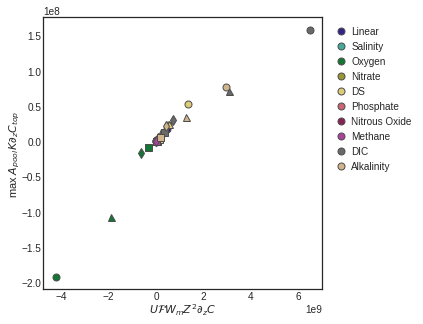

In [11]:
sns.set_style('white')
sns.set_context('notebook')

fig, ax0=plt.subplots(1,1,figsize=(5,5))

labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','DS',
              'Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677',
           '#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01',
        'UPW_10TR_BF4_BAR_03']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']

runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']

can_Area = [1.8E8, 1.8E8, 8.7E7, 8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_grad0 = [sb_grad0_A,sb_grad0_A, sb_grad0_B,sb_grad0_B]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradtop = [sb_gradtop_Ast,sb_gradtop_Argo, sb_gradtop_Bar,sb_gradtop_Path]
Hhs = [97.5,97.5,172.5,172.,5]
Hss = [150,150,200,200]

area_array = np.zeros(40)
Pi_array = np.zeros(40)
kk = 0

for tr, tr_lab, factor, ii, col in zip(tracer_keys, labels_tra, factors, range(len(labels_tra)),colours):
    for file, run,run_phi,lab_exp, can_area,exp, \
    grad0,grad,gradtop,conc,Hh,ff,nn,uu,ll,ww,wsb,ss,KK,rr, mark in zip(exp_files, 
                                                                        runs,runs_phi,
                                                                        labels_exp,
                                                                        can_Area,exps,
                                                                        sb_grad0,
                                                                        sb_grad,
                                                                        sb_gradtop,
                                                                        sb_conc,Hhs,
                                                                        f,N,U,L,Wiso,
                                                                        Wsbs,s,K,R,
                                                                        markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Cs=conc[ii]
        Wsb = wsb
        calF = F(Ro(uu,ff,rr))
        
        file2 = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run_phi))
        df = pd.read_csv(file2)
        if (tr == 'phiTr07' or tr == 'phiTr08'):
            TrMass = df[tr][:]# nMm^3s to muMm^3/s and muMm^3/s to mumol/s
            HCW = df['Phi'][:]# m^3/s
        else:
            TrMass = df[tr][:]/1E-3 # nMm^3/s to muMm^3/s and muMm^3/s to mumol/s
            HCW = df['Phi'][:]# m^3/s 
        
        PhiTr = np.mean(np.array(TrMass[8:18]))
        Phi = np.mean(np.array(HCW[8:18]))
        
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax0.plot(Phi*ZZ*grad[ii],(KK*gradtop[ii])*np.nanmax(area[ii,:]),
                             'o', mfc = col, mec='0.3',mew=1, 
                             label = tr_lab)
                    Pi_array[kk]=((uu*(ZZ**2)*grad[ii]*Wsb*(calF))/(KK*gradtop[ii]))
                    area_array[kk]=np.nanmax(area[ii,:])
                    print(uu*calF*Wsb*(ZZ**2)*grad[ii])
                    print(KK*gradtop[ii]*np.nanmax(area[ii,:]))
                    print(ZZ)
                else:
                    ax0.plot(Phi*ZZ*grad[ii],(KK*gradtop[ii])*np.nanmax(area[ii,:]),
                              '^', mfc = col, mec='0.3',mew=1) 
                    Pi_array[kk]=((uu*(ZZ**2)*grad[ii]*Wsb*(calF))/(KK*gradtop[ii]))
                    area_array[kk]=np.nanmax(area[ii,:])
            else:
                if lab_exp=='BAR':
                    ax0.plot(Phi*ZZ*grad[ii],(KK*gradtop[ii])*np.nanmax(area[ii,:]),
                             's', mfc = col, mec='0.3',mew=1)
                    Pi_array[kk]=(uu*(ZZ**2)*grad[ii]*Wsb*(calF)/(KK*gradtop[ii]))
                    area_array[kk]=np.nanmax(area[ii,:])
                else:
                    ax0.plot(Phi*ZZ*grad[ii],(KK*gradtop[ii])*np.nanmax(area[ii,:]),
                            'd', mfc = col, mec='0.3',mew=1)
                    Pi_array[kk]=(uu*(ZZ**2)*grad[ii]*Wsb*(calF)/(KK*gradtop[ii]))
                    area_array[kk]=np.nanmax(area[ii,:])
        
            kk=kk+1     
         
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)

ax0.legend(bbox_to_anchor=(1,1), handletextpad=0)

#legend_elements = [Line2D([0], [0], marker='o',color='w', label='AST',
#                          markerfacecolor='k', mec='k',markersize=7),
#                   Line2D([0], [0], marker='^',color='w', label='ARGO',
#                           markerfacecolor='k', mec='k',markersize=7),
#                    Line2D([0], [0], marker='s',color='w', label='BAR',
#                           markerfacecolor='k', mec='k',markersize=7),
#                    Line2D([0], [0], marker='d',color='w', label='PATH',
#                           markerfacecolor='k', mec='k',markersize=7),
#                    ]


#ax0.legend(handles=legend_elements, bbox_to_anchor=(1.5,1), handletextpad=0)
ax0.set_xlabel(r'$U\mathcal{F}W_mZ^2\partial_zC$', labelpad=0)
ax0.set_ylabel(r'max $A_{pool} K \partial_zC_{top}$', labelpad=0)

slope0, intercept0, r_value0, p_value0, std_err0 = scipy.stats.linregress(Pi_array,area_array)

print('slope = %1.2e, intercept = %1.3f, r-value = %1.3f, std_err = %1.3e' \
      %(slope0, intercept0, r_value0, std_err0))


In [16]:
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]
markers=['o','^','s','d']

exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']
runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']

sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_grad0 = [sb_grad0_A,sb_grad0_A, sb_grad0_B,sb_grad0_B]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradtop = [sb_gradtop_Ast,sb_gradtop_Argo, sb_gradtop_Bar,sb_gradtop_Path]
Hhs = [97.5,97.5,172.5,172.,5]

Phi_array = np.zeros(40)
x_array = np.zeros(40)
kk = 0

for tr, ii in zip(tracer_keys, range(len(labels_tra))):
    for run_phi,lab_exp,exp,grad,conc,ff,nn,uu,ll,ww,ss, mark in zip(runs_phi,
                                                                     labels_exp,
                                                                     exps,
                                                                     sb_grad,
                                                                     sb_conc,
                                                                     f,N,U,L,Wiso,s,
                                                                     markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Cs=conc[ii]
        
        file = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run_phi))
        df = pd.read_csv(file)
        if (tr == 'phiTr07' or tr == 'phiTr08'):
            TrMass = df[tr][:]# nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = df['Phi'][:]# m^3 
        else:
            TrMass = 1E3*df[tr][:] # nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = df['Phi'][:]# m^3 
        
        PhiTr = np.mean(np.array(TrMass[8:18]))
        Phi = np.mean(np.array(HCW[8:18]))
        Phi_array[kk]=PhiTr/(Phi*Cs)
        x_array[kk] = ZZ*grad[ii]/Cs
        kk = kk+1 

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_array,Phi_array)

print('slope = %1.2f, intercept = %1.3f, r-value = %1.3f, std_err = %1.3f' \
      %(slope, intercept, r_value, std_err))


slope = 0.57, intercept = 0.982, r-value = 0.966, std_err = 0.025


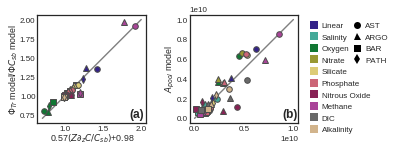

In [19]:
sns.set_style('white')
sns.set_context('paper')

fig,(ax0,ax1) =plt.subplots(1,2,figsize=(5,2))
   
labels_exp = ['AST', 'ARGO','BAR', 'PATH']
labels_tra = ['Linear','Salinity','Oxygen','Nitrate','Silicate','Phosphate','Nitrous Oxide','Methane','DIC','Alkalinity']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'dimgray', 'tan']
tracer_keys = ['phiTr01','phiTr02','phiTr03','phiTr04','phiTr05','phiTr06',
              'phiTr07','phiTr08','phiTr09','phiTr10']
exp_files = ['../saved_calcs/pool_AST.nc',
             '../saved_calcs/pool_ARGO.nc',
             '../saved_calcs/pool_BAR.nc',
             '../saved_calcs/pool_PATH.nc']
runs = ['UPW_10TR_BF2_AST_01','UPW_10TR_BF2_AST_03','UPW_10TR_BF4_BAR_01','UPW_10TR_BF4_BAR_03']
markers=['o','^','s','d']
exps = ['UPW_10TR_BF2_AST','UPW_10TR_BF2_AST','UPW_10TR_BF4_BAR','UPW_10TR_BF4_BAR']
runs_phi = ['01_Ast03','03_Ast03_Argo','01_Bar03','03_Bar03_Path']
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]
sb_grad = [sb_gradZ_Ast,sb_gradZ_Argo, sb_gradZ_Bar,sb_gradZ_Path]
sb_gradtop = [sb_gradtop_Ast,sb_gradtop_Argo, sb_gradtop_Bar,sb_gradtop_Path]

ax0.plot(np.linspace(0.7,2,20),np.linspace(0.7,2,20),'-',color='0.5')
ax1.plot(np.linspace(0,1E10,50),
         np.linspace(0,1E10,50),'-',color='0.5')

for tr_lab,tr, ii, col in zip(labels_tra,tracer_keys, range(len(labels_tra)),colours):
    for file,run,run_phi,lab_exp,can_area,exp,grad,gradtop,conc,ff,nn,uu,ll,ww,wsb,ss,KK,rr, mark in zip(exp_files,
                                                                                                          runs,
                                                                                                          runs_phi,
                                                                                                          labels_exp,
                                                                                                          can_Area,                
                                                                                                          exps,
                                                                                                          sb_grad,
                                                                                                          sb_gradtop,
                                                                                                          sb_conc,
                                                                                                          f,N,U,L,Wiso,Wsbs,
                                                                                                          s,K,R,
                                                                                                          markers):

        ZZ = Z(uu,ff,ll,ww,nn,ss)*Dh(ff,ll,nn)
        Cs=conc[ii]
        Wsb = wsb
        calF = F(Ro(uu,ff,rr))
        file2 = ('/data/kramosmu/results/TracerExperiments/%s/phi_phiTr_transAlg_%s.csv' %(exp,run_phi))
        df = pd.read_csv(file2)
        if (tr == 'phiTr07' or tr == 'phiTr08'):
            TrMass = df[tr][:]# nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = df['Phi'][:]# m^3 to l
        else:
            TrMass = 1E3*df[tr][:] # nMm^3 to muMm^3 and muMm^3 to mumol
            HCW = df['Phi'][:]# m^3 to l
        PhiTr = np.mean(np.array(TrMass[8:18]))
        Phi = np.mean(np.array(HCW[8:18]))
    
        ax0.plot(slope*(ZZ*grad[ii]/Cs)+intercept,PhiTr/(Phi*Cs), marker=mark,markerfacecolor=col, 
                 markeredgecolor='0.3', markeredgewidth=1)
       
        # Plot area vs tau
        with Dataset(file, 'r') as nbl:
            area = nbl.variables['area']
            if can_area > 8.8E7:
                if lab_exp=='AST':
                    ax1.plot(slope0*(uu*ZZ**2*Wsb*calF*grad[ii]/(KK*gradtop[ii]))+intercept0,
                             np.nanmax(area[ii,:]), 'o', mfc = col, mec='0.3',
                             mew=1, label = tr_lab)
                else:
                    ax1.plot(slope0*(uu*ZZ**2*Wsb*calF*grad[ii]/(KK*gradtop[ii]))+intercept0,
                             np.nanmax(area[ii,:]), '^', mfc = col, mec='0.3',
                             mew=1)
            else:
                if lab_exp=='BAR':
                    ax1.plot(slope0*(uu*ZZ**2*Wsb*calF*grad[ii]/(KK*gradtop[ii]))+intercept0,
                             np.nanmax(area[ii,:]), 's', mfc = col, mec='0.3',
                             mew=1)
                else:
                    ax1.plot(slope0*(uu*ZZ**2*Wsb*calF*grad[ii]/(KK*gradtop[ii]))+intercept0,
                             np.nanmax(area[ii,:]), 'd', mfc = col, mec='0.3',
                             mew=1)
ax0.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=2)
ax1.xaxis.set_tick_params(pad=2)
ax1.yaxis.set_tick_params(pad=2)

legend_runs     = [Line2D([0], [0], marker='o',color='w', label='AST',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='^',color='w', label='ARGO',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='s',color='w', label='BAR',
                          markerfacecolor='k', mec='k',markersize=7),
                   Line2D([0], [0], marker='d',color='w', label='PATH',
                          markerfacecolor='k', mec='k',markersize=7),
                   ]
ax0.legend(handles=legend_runs,bbox_to_anchor=(3.3,1.0), handletextpad=0)

legend_elements=[]
for ii in range(len(colours)):
    legend_elements.append(Line2D([0], [0], marker='s',color='w', label=labels_tra[ii],
                           markerfacecolor=colours[ii], mec=colours[ii],markersize=8),)

ax1.legend(handles=legend_elements, bbox_to_anchor=(1,1), handletextpad=0)
#ax1.set_xlabel(r'%1.2e$\Pi $%1.2f' %(slope0,intercept0), labelpad=0)
ax0.set_xlabel(r'%1.2f$(Z \partial_zC/C_{sb})$+%1.2f' %(slope,intercept), labelpad=0)

ax0.set_ylabel('$\Phi_{Tr}$ model/$\Phi C_{sb}$ model', labelpad=0)
ax1.set_ylabel('$A_{pool}$ model', labelpad=0)
ax0.set_aspect(1)
ax1.set_aspect(1)

ax0.text(0.85,0.05,'(a)',fontsize=12, fontweight='bold',  transform=ax0.transAxes)
ax1.text(0.85,0.05,'(b)',fontsize=12, fontweight='bold',  transform=ax1.transAxes)

plt.savefig('scaling.eps',format='eps', bbox_inches='tight')

In [ ]:
40 * 0.5 * (20000 * 10000) 

In [ ]:
(21.8E3*15.7E3)/2